## General information

Correctly predicting earthquakes is very important for preventing deaths and damage to infrastructure. In this competition we try to predict time left to the next laboratory earthquake based on seismic signal data.
Training data represents one huge signal, but in test data we have many separate chunks, for each of which we need to predict time to failure.

This is my second kernel for this competition, here is the [link](https://www.kaggle.com/artgor/seismic-data-eda-and-baseline) to the first one.

In this kernel I'll try to create more useful features and generate more data for training.

![](https://i.cbc.ca/1.4972912.1547133821!/fileImage/httpImage/image.jpg_gen/derivatives/16x9_780/new-brunswick-earthquake.jpg)

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge

In [2]:
%%time
train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 1min 6s, sys: 22.5 s, total: 1min 28s
Wall time: 1min 14s


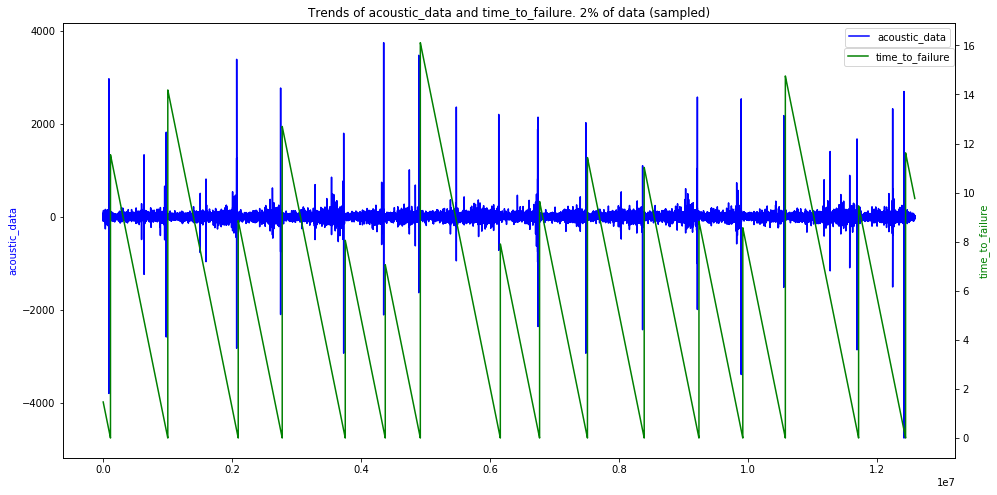

In [3]:
train_acoustic_data_small = train['acoustic_data'].values[::50]
train_time_to_failure_small = train['time_to_failure'].values[::50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Trends of acoustic_data and time_to_failure. 2% of data (sampled)")
plt.plot(train_acoustic_data_small, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='g')
ax2.set_ylabel('time_to_failure', color='g')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

In [14]:
train.acoustic_data[0:10].values

array([12,  6,  8,  5,  8,  8,  9,  7, -5,  3], dtype=int16)

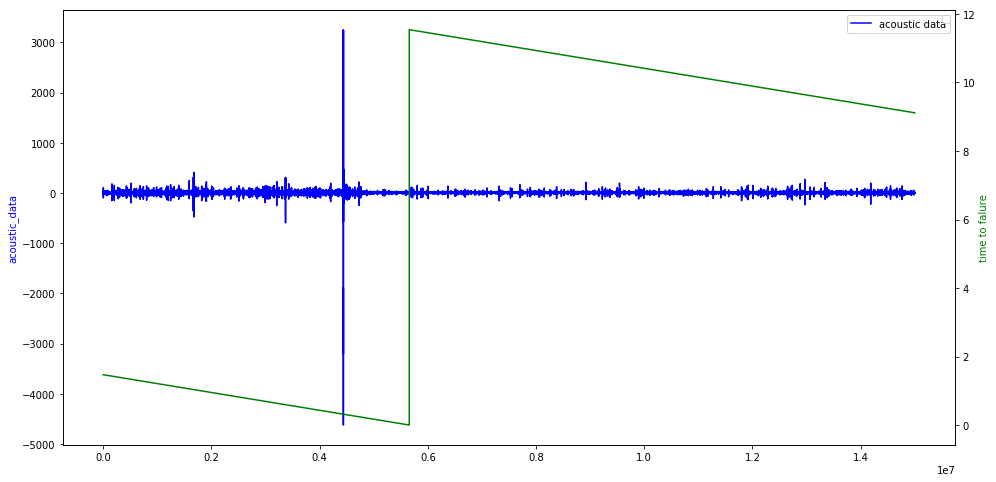

In [43]:
a = 0
b = 15000000

fig, ax1 = plt.subplots(figsize=(16,8))
plt.plot(train.acoustic_data.iloc[a:b].values, color='blue')
plt.legend(['acoustic data'])
ax1.set_ylabel('acoustic_data', color='b')
ax2 = ax1.twinx()
plt.legend(['time to falure'])
ax2.set_ylabel('time to falure', color='g')
plt.plot(train.time_to_failure.iloc[a:b].values, color='green')

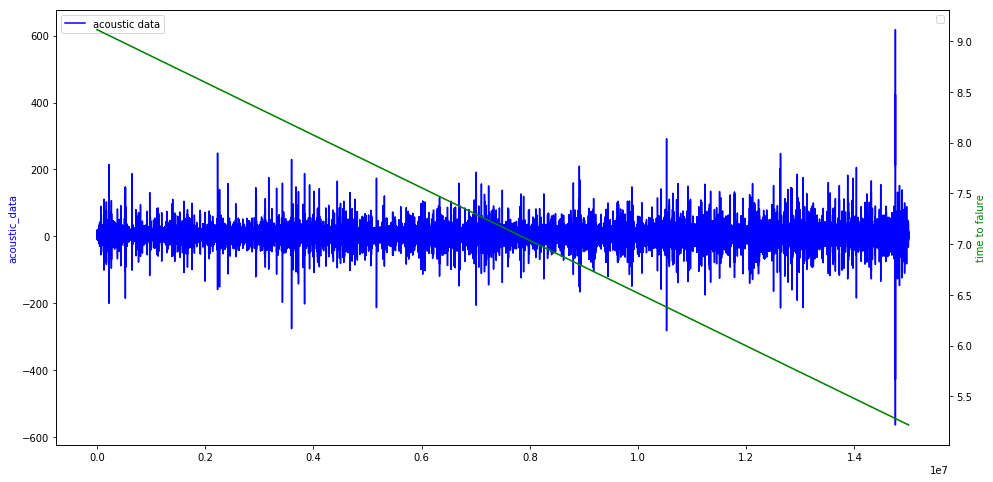

In [44]:
a = 15000000
b = 30000000

fig, ax1 = plt.subplots(figsize=(16,8))
plt.plot(train.acoustic_data.iloc[a:b].values, color='blue')
plt.legend(['acoustic data'])
ax1.set_ylabel('acoustic_data', color='b')
ax2 = ax1.twinx()
plt.legend(['time to falure'])
ax2.set_ylabel('time to falure', color='g')
plt.plot(train.time_to_failure.iloc[a:b].values, color='green')

In [35]:
print(train.time_to_failure[0])
print(train.time_to_failure[150000])
print(train.time_to_failure[0] - train.time_to_failure[150000])

1.4691
1.4307972
0.03830278


In [40]:
(train.shape[0] / 150000) * (train.time_to_failure[0] - train.time_to_failure[150000])

160.65346935777666

* We can see that usually acoustic data shows huge fluctuations just before the failure and the nature of data is cyclical;
* Another important point: visually failures can be predicted as cases when huge fluctuations in signal are followed by small signal values. This could be useful for predicting "time_to_failure" changes from 0 to high values;
* I thought that comparing max values of signal in a segment to some threshold value (1000 or 2000) could be useful, but it didn't work;

## Feature generation

I create several groups of features:
* Usual aggregations: mean, std, min and max;
* Average difference between the consequitive values in absolute and percent values;
* Absolute min and max vallues;
* Aforementioned aggregations for first and last 10000 and 50000 values - I think these data should be useful;
* Max value to min value and their differencem also count of values bigger that 500 (arbitrary threshold);
* Quantile features from this kernel: https://www.kaggle.com/andrekos/basic-feature-benchmark-with-quantiles
* Trend features from this kernel: https://www.kaggle.com/jsaguiar/baseline-with-abs-and-trend-features
* Rolling features from this kernel: https://www.kaggle.com/wimwim/rolling-quantiles

In [3]:
%%time
# Create a training file with simple derived features
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)

y_tr = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

total_mean = train['acoustic_data'].mean()
total_std = train['acoustic_data'].std()
total_max = train['acoustic_data'].max()
total_min = train['acoustic_data'].min()
total_sum = train['acoustic_data'].sum()
total_abs_sum = np.abs(train['acoustic_data']).sum()

for segment in tqdm_notebook(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]
    
    y_tr.loc[segment, 'time_to_failure'] = y
    X_tr.loc[segment, 'mean'] = x.mean()
    X_tr.loc[segment, 'std'] = x.std()
    X_tr.loc[segment, 'max'] = x.max()
    X_tr.loc[segment, 'min'] = x.min()
    
    
    X_tr.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_tr.loc[segment, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_tr.loc[segment, 'abs_max'] = np.abs(x).max()
    X_tr.loc[segment, 'abs_min'] = np.abs(x).min()
    
    X_tr.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_tr.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_tr.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_tr.loc[segment, 'std_last_10000'] = x[-10000:].std()
    
    X_tr.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_tr.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_tr.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_tr.loc[segment, 'avg_last_10000'] = x[-10000:].mean()
    
    X_tr.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_tr.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_tr.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_tr.loc[segment, 'min_last_10000'] = x[-10000:].min()
    
    X_tr.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_tr.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_tr.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_tr.loc[segment, 'max_last_10000'] = x[-10000:].max()
    
    X_tr.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_tr.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])
    X_tr.loc[segment, 'sum'] = x.sum()
    
    X_tr.loc[segment, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_tr.loc[segment, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)
    
    X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_tr.loc[segment, 'trend'] = add_trend_feature(x)
    X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
    
    X_tr.loc[segment, 'mad'] = x.mad()
    X_tr.loc[segment, 'kurt'] = x.kurtosis()
    X_tr.loc[segment, 'skew'] = x.skew()
    X_tr.loc[segment, 'med'] = x.median()
    
    X_tr.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_tr.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_tr.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_tr.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_tr.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_tr.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_tr.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X_tr.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X_tr.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X_tr.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_tr.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_tr.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_tr.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 3
    X_tr.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_tr.loc[segment,'MA_700MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment,'MA_700MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_700MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_tr.loc[segment,'MA_400MA_BB_high_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment,'MA_400MA_BB_low_mean'] = (X_tr.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_tr.loc[segment, 'MA_400MA_std_mean']).mean()
    X_tr.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_tr.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X_tr.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_tr.loc[segment, 'q999'] = np.quantile(x,0.999)
    X_tr.loc[segment, 'q001'] = np.quantile(x,0.001)
    X_tr.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_tr.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_tr.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_tr.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_tr.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_tr.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_tr.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_tr.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_tr.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_tr.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_tr.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_tr.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_tr.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_tr.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_tr.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_tr.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_tr.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_tr.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_tr.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_tr.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_tr.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()


CPU times: user 1h 19min 4s, sys: 2min 5s, total: 1h 21min 10s
Wall time: 13min 43s


In [11]:
X_tr[X_tr['classic_sta_lta5_mean'] == -np.inf]

,mean,std,max,min,mean_change_abs,mean_change_rate,abs_max,abs_min,std_first_50000,std_last_50000,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
325,4.307920000000000,142.976883403815265,3914.0,-3301.0,0.000086667244448,76190.868365867834655,3914.0,0.0,7.818086701872368,247.192591698752608,...,2.464196737116011,47.052000000000000,-38.398000000000003,-1.535,2.206,5.562,9.731999999999999,0.000000684563758,75397.291861625693855,47.052000000000000
467,5.045880000000000,8.596354324614467,346.0,-268.0,0.000006666711111,74893.878878385658027,346.0,0.0,11.293646959208207,8.949201882843340,...,0.216171793010943,6.863000000000000,2.618000000000000,4.570,4.703,5.379,5.550000000000000,0.000000342281879,74357.484568688465515,6.863000000000000
668,4.915353333333333,22.143573120148410,650.0,-580.0,0.000006666711111,75201.042847089120187,650.0,0.0,12.135532776714646,34.804303334573611,...,0.313543193535403,9.132000000000000,1.568000000000000,4.306,4.461,5.315,5.549000000000000,0.000000322147651,74681.016213553419220,9.132000000000000
689,4.991000000000000,112.780726407255969,4610.0,-3112.0,0.000020000133334,76110.898892853205325,4610.0,0.0,11.867894324129860,194.881964796813492,...,2.250799781941951,43.566000000000003,-27.332000000000001,-1.691,2.687,6.489,10.792999999999999,-0.000012664429530,75224.525107897919952,43.566000000000003
1234,4.434593333333333,15.027793390862483,435.0,-472.0,-0.000013333422223,74921.281184311912511,472.0,0.0,17.136885108053448,7.348981169664584,...,0.254458046966071,6.463000000000000,2.633000000000000,3.890,4.031,4.880,5.119000000000000,-0.000001281879195,74472.535208050816436,6.463000000000000
1756,4.097740000000000,7.861263610610174,281.0,-316.0,-0.000046666977780,75001.247261807511677,316.0,0.0,4.163117515342190,12.052353100648242,...,0.230132312255021,5.233000000000000,3.318000000000000,3.619,3.721,4.478,4.596000000000000,-0.000003429530201,74529.259280390309868,5.233000000000000
2453,4.511500000000000,10.147959119473001,322.0,-308.0,0.000013333422223,74717.467462381435325,322.0,0.0,15.312244554495136,5.293575392757599,...,0.222906023962801,6.174000000000000,3.339000000000000,4.018,4.134,4.857,5.094000000000000,-0.000003395973154,74143.398778793052770,6.174000000000000
2674,4.325253333333333,9.307368467145128,357.0,-330.0,-0.000113334088894,75001.856495262851240,357.0,0.0,14.316955875622124,4.933366565917585,...,0.318825411324698,7.097000000000000,2.849000000000000,3.713,3.893,4.846,4.992000000000000,-0.000006771812081,74425.029590327030746,7.097000000000000
4037,4.395093333333334,9.813737819384729,227.0,-232.0,-0.000006666711111,75062.600034628383582,232.0,0.0,5.384644598109420,9.729296658642362,...,0.253990373515797,5.586000000000000,3.579000000000000,3.769,3.954,4.803,4.923000000000000,-0.000002724832215,74594.655143247524393,5.586000000000000


In [12]:
# fillna in new columns
classic_sta_lta5_mean_fill = X_tr.loc[X_tr['classic_sta_lta5_mean'] != -np.inf, 'classic_sta_lta5_mean'].mean()
X_tr.loc[X_tr['classic_sta_lta5_mean'] == -np.inf, 'classic_sta_lta5_mean'] = classic_sta_lta5_mean_fill
X_tr['classic_sta_lta5_mean'] = X_tr['classic_sta_lta5_mean'].fillna(classic_sta_lta5_mean_fill)
classic_sta_lta7_mean_fill = X_tr.loc[X_tr['classic_sta_lta7_mean'] != -np.inf, 'classic_sta_lta7_mean'].mean()
X_tr.loc[X_tr['classic_sta_lta7_mean'] == -np.inf, 'classic_sta_lta7_mean'] = classic_sta_lta7_mean_fill
X_tr['classic_sta_lta7_mean'] = X_tr['classic_sta_lta7_mean'].fillna(classic_sta_lta7_mean_fill)

In [13]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_tr_poly = poly.fit_transform(X_tr)

In [14]:
X_tr_poly_df = pd.DataFrame(X_tr_poly)

In [15]:
X_tr_poly_df.head()

,0,1,2,3,4,5,6,7,8,9,...,9720,9721,9722,9723,9724,9725,9726,9727,9728,9729
0,1.0,4.884113333333334,5.101106130606765,104.0,-98.0,-0.000080000533337,74836.577199220613693,104.0,0.0,6.488551888989741,...,30.074255999999998,-0.000009348563758,407035.331439442234114,30.869435999999997,0.000000000002906,-0.126526679425710,-0.000009595744966,5.508956266117327e+09,417797.571238625154365,31.685640999999993
1,1.0,4.725766666666667,6.588823781946801,181.0,-154.0,0.000000000000000,74891.736231905975728,181.0,0.0,7.305232697765033,...,27.279729000000000,-0.000012794597315,388405.399492126831319,29.598740999999997,0.000000000006001,-0.182167890364413,-0.000013882248322,5.530067925331614e+09,421423.204848149092868,32.114888999999998
2,1.0,4.906393333333333,6.967397033524431,140.0,-106.0,-0.000013333422223,75099.224450501744286,140.0,0.0,6.104836457315087,...,30.096195999999999,0.000006259194631,409228.085430427745450,32.680101999999998,0.000000000001302,0.085108371673562,0.000006796577181,5.564411725158006e+09,444362.323169715295080,35.485849000000002
3,1.0,4.902240000000000,6.922305187180113,197.0,-199.0,0.000000000000000,74933.991878648565034,199.0,0.0,6.238109475682244,...,29.735209000000005,-0.000013906979866,405338.632174111960921,31.943674000000001,0.000000000006504,-0.189574460245592,-0.000014939865772,5.525416240820101e+09,435443.555341270461213,34.316163999999993
4,1.0,4.908720000000000,7.301110189758817,145.0,-126.0,-0.000006666711111,75010.016045975266024,145.0,0.0,5.323829516204886,...,30.151080999999998,0.000008512892617,408686.541905143298209,33.374297999999996,0.000000000002404,0.115389051736995,0.000009422939597,5.539592080774301e+09,452376.033818878408056,36.942084000000001


In [18]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='mean')

X_tr2_array = imp.fit_transform(X_tr_poly_df)

X_tr2 = pd.DataFrame(X_tr2_array)

In [29]:
print(X_tr2.shape)
X_tr2.head()

(4194, 9730)


,0,1,2,3,4,5,6,7,8,9,...,9720,9721,9722,9723,9724,9725,9726,9727,9728,9729
0,1.0,4.884113333333334,5.101106130606765,104.0,-98.0,-0.000080000533337,74836.577199220613693,104.0,0.0,6.488551888989741,...,30.074255999999998,-0.000009348563758,407035.331439442234114,30.869435999999997,0.000000000002906,-0.126526679425710,-0.000009595744966,5.508956266117327e+09,417797.571238625154365,31.685640999999993
1,1.0,4.725766666666667,6.588823781946801,181.0,-154.0,0.000000000000000,74891.736231905975728,181.0,0.0,7.305232697765033,...,27.279729000000000,-0.000012794597315,388405.399492126831319,29.598740999999997,0.000000000006001,-0.182167890364413,-0.000013882248322,5.530067925331614e+09,421423.204848149092868,32.114888999999998
2,1.0,4.906393333333333,6.967397033524431,140.0,-106.0,-0.000013333422223,75099.224450501744286,140.0,0.0,6.104836457315087,...,30.096195999999999,0.000006259194631,409228.085430427745450,32.680101999999998,0.000000000001302,0.085108371673562,0.000006796577181,5.564411725158006e+09,444362.323169715295080,35.485849000000002
3,1.0,4.902240000000000,6.922305187180113,197.0,-199.0,0.000000000000000,74933.991878648565034,199.0,0.0,6.238109475682244,...,29.735209000000005,-0.000013906979866,405338.632174111960921,31.943674000000001,0.000000000006504,-0.189574460245592,-0.000014939865772,5.525416240820101e+09,435443.555341270461213,34.316163999999993
4,1.0,4.908720000000000,7.301110189758817,145.0,-126.0,-0.000006666711111,75010.016045975266024,145.0,0.0,5.323829516204886,...,30.151080999999998,0.000008512892617,408686.541905143298209,33.374297999999996,0.000000000002404,0.115389051736995,0.000009422939597,5.539592080774301e+09,452376.033818878408056,36.942084000000001


### On sampling

I tried to randomly sample 150000 rows 1k-10k times and add these samples to training data, but it severely decreased my score.

In [43]:
np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(12)

q05_roll_std_100         0.648824447085559
q01_roll_std_100         0.644797095592989
q05_roll_std_10          0.643123220257531
q01_roll_std_10          0.635263713488480
q05_roll_std_1000        0.614482273757697
q01_roll_std_1000        0.603691188925208
classic_sta_lta5_mean    0.577312962122630
min_roll_std_1000        0.544294240126950
classic_sta_lta7_mean    0.510456411541754
iqr                      0.506994140262580
classic_sta_lta6_mean    0.444735193498527
q95_roll_std_10          0.439754146578064
dtype: float64

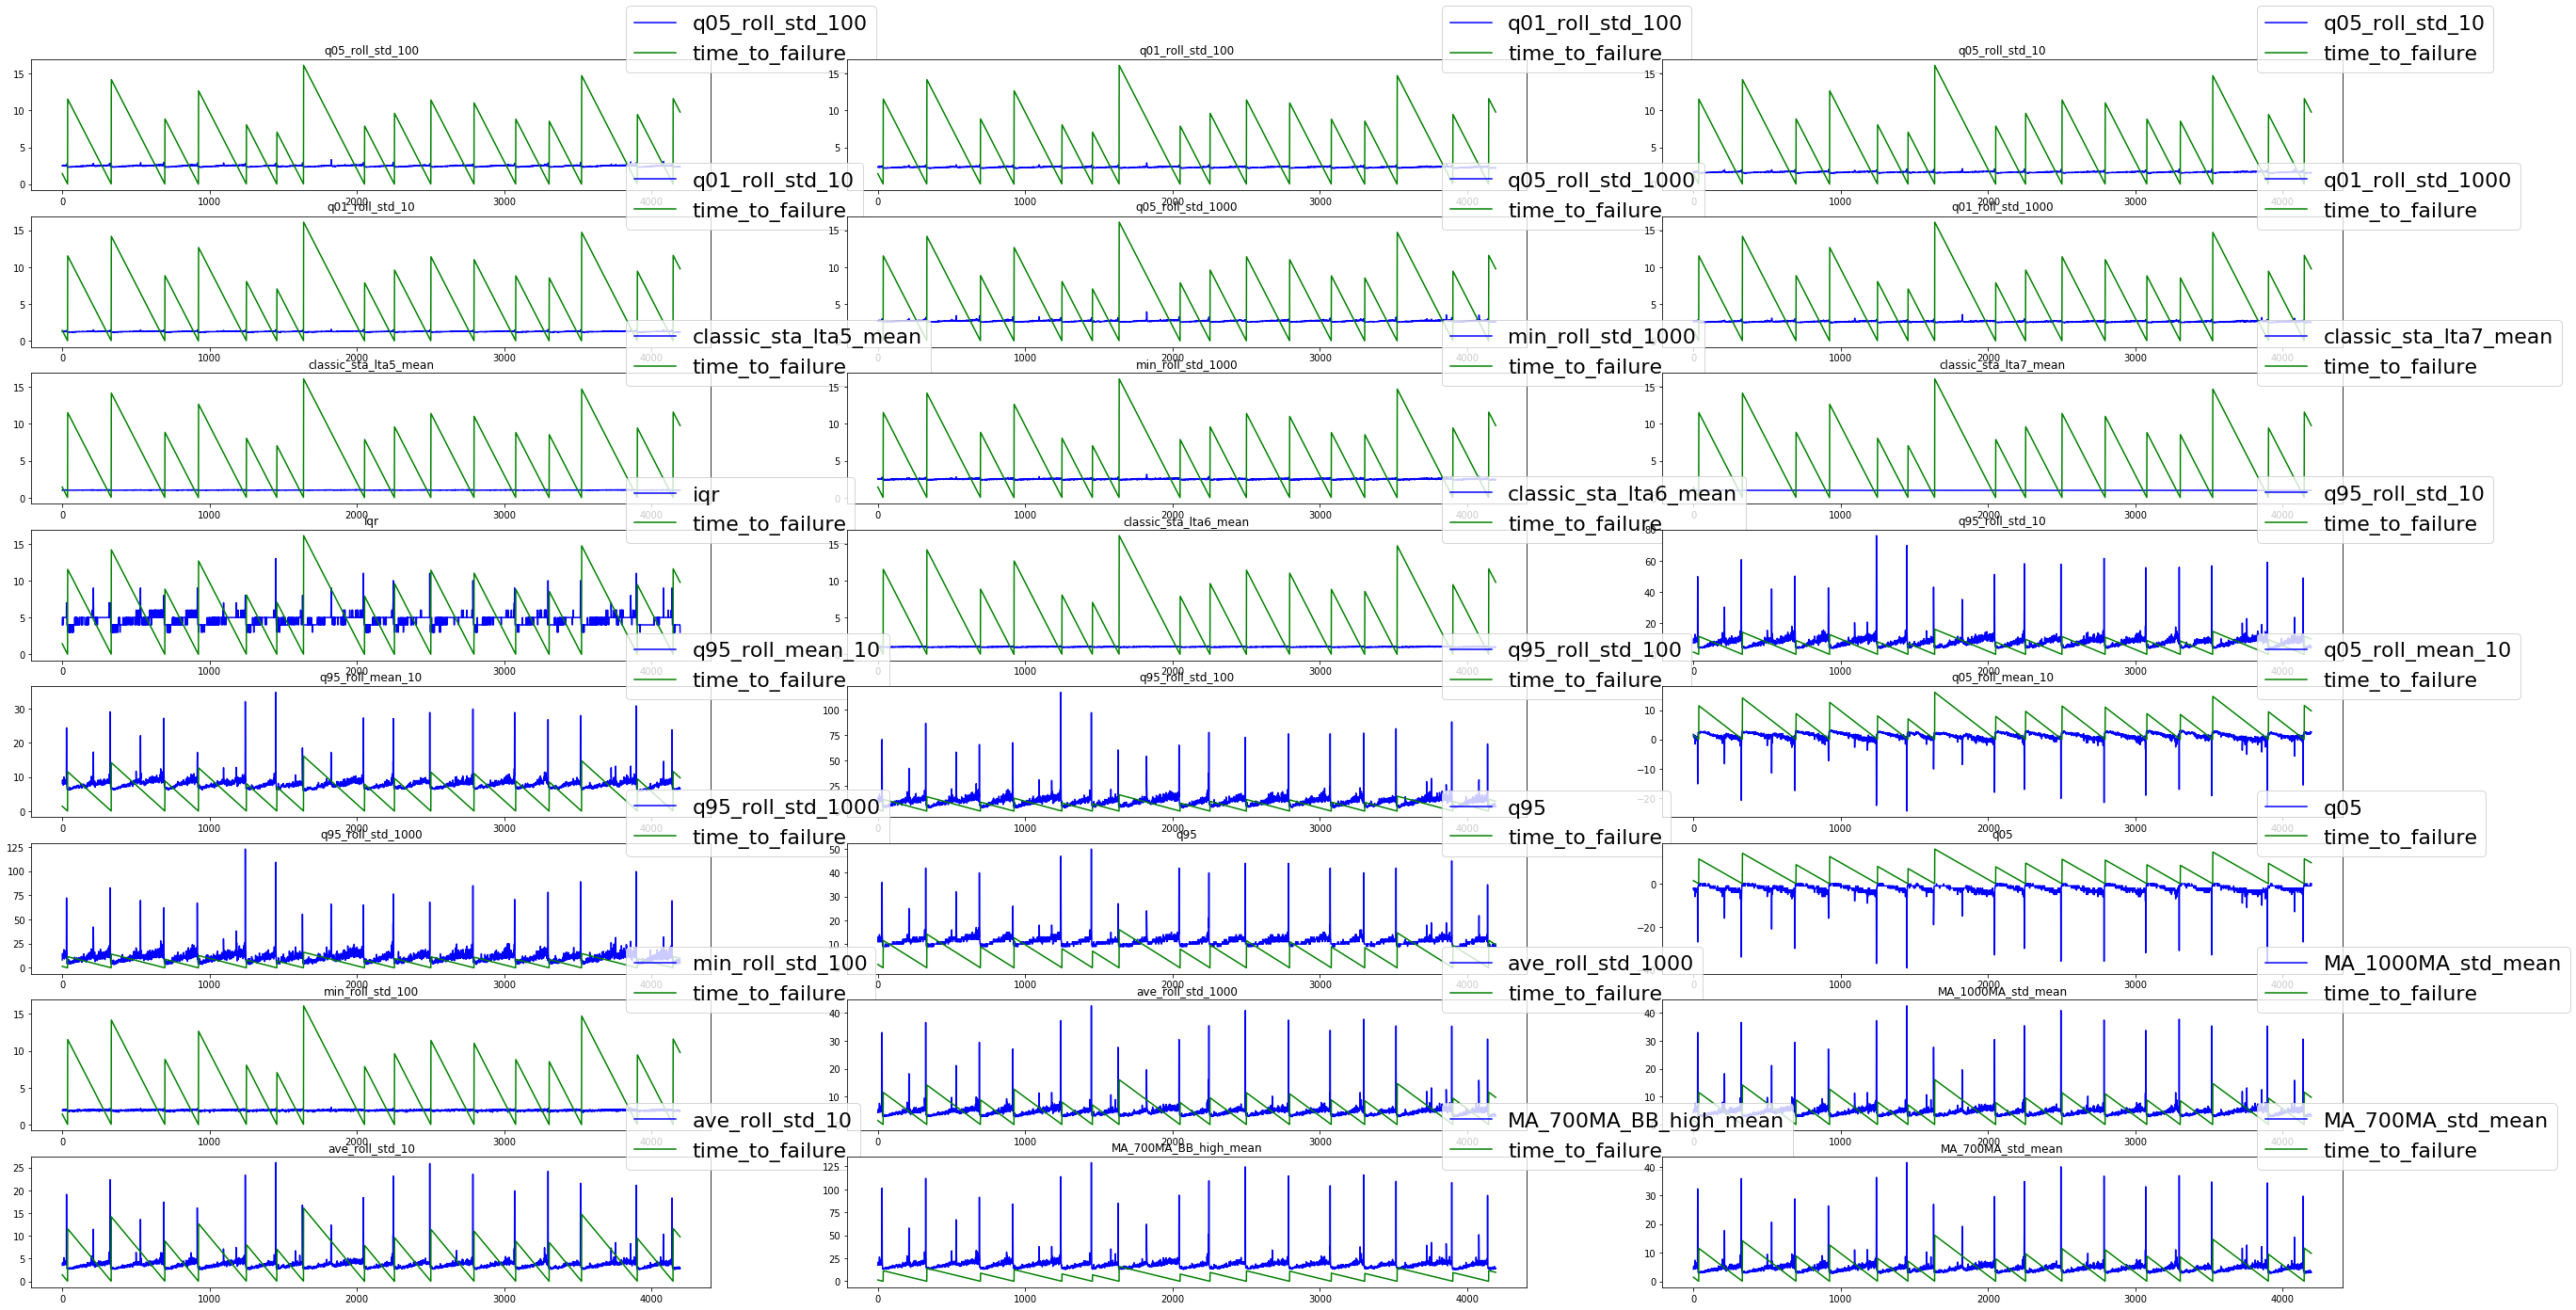

In [35]:
plt.figure(figsize=(44, 24))
cols = list(np.abs(X_tr.corrwith(y_tr['time_to_failure'])).sort_values(ascending=False).head(24).index)
for i, col in enumerate(cols):
    plt.subplot(8, 3, i + 1)
    plt.plot(X_tr[col], color='blue')
    plt.title(col)
    ax1.set_ylabel(col, color='b')

    ax2 = ax1.twinx()
    plt.plot(y_tr, color='g')
    ax2.set_ylabel('time_to_failure', color='g')
    plt.legend([col, 'time_to_failure'], loc=(0.875, 0.9), fontsize=22)
    plt.grid(False)

In [32]:
scaler = StandardScaler()
scaler.fit(X_tr2)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [33]:
X_train_scaled = pd.DataFrame(scaler.transform(X_tr2))

### Reading test dat

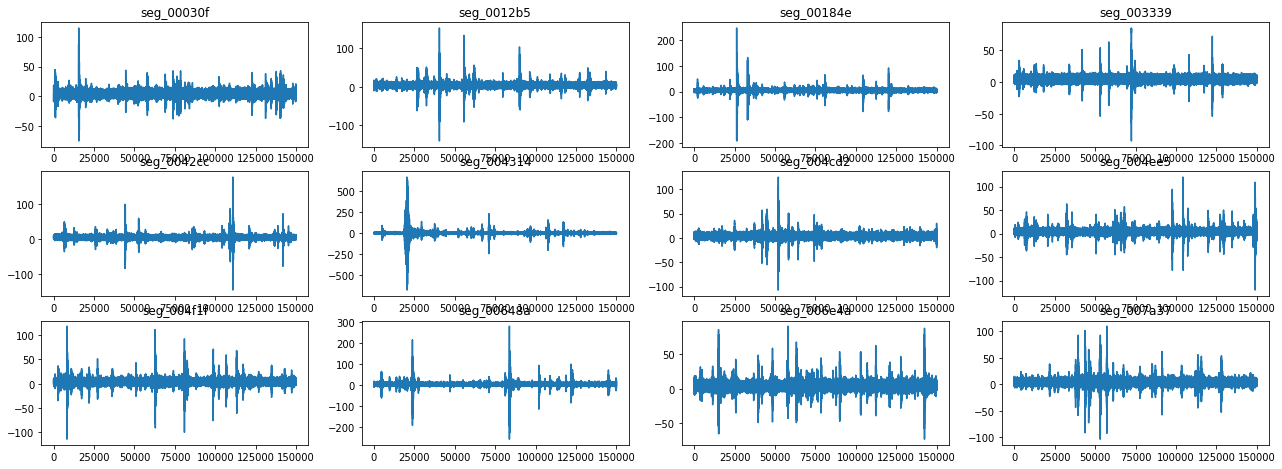

In [34]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
plt.figure(figsize=(22, 16))

for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
    seg = pd.read_csv('test/' + seg_id + '.csv')
    
    x = pd.Series(seg['acoustic_data'].values)
    X_test.loc[seg_id, 'mean'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
        
    X_test.loc[seg_id, 'mean_change_abs'] = np.mean(np.diff(x))
    X_test.loc[seg_id, 'mean_change_rate'] = np.mean(np.nonzero((np.diff(x) / x[:-1]))[0])
    X_test.loc[seg_id, 'abs_max'] = np.abs(x).max()
    X_test.loc[seg_id, 'abs_min'] = np.abs(x).min()
    
    X_test.loc[seg_id, 'std_first_50000'] = x[:50000].std()
    X_test.loc[seg_id, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[seg_id, 'std_first_10000'] = x[:10000].std()
    X_test.loc[seg_id, 'std_last_10000'] = x[-10000:].std()
    
    X_test.loc[seg_id, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[seg_id, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[seg_id, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[seg_id, 'avg_last_10000'] = x[-10000:].mean()
    
    X_test.loc[seg_id, 'min_first_50000'] = x[:50000].min()
    X_test.loc[seg_id, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[seg_id, 'min_first_10000'] = x[:10000].min()
    X_test.loc[seg_id, 'min_last_10000'] = x[-10000:].min()
    
    X_test.loc[seg_id, 'max_first_50000'] = x[:50000].max()
    X_test.loc[seg_id, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[seg_id, 'max_first_10000'] = x[:10000].max()
    X_test.loc[seg_id, 'max_last_10000'] = x[-10000:].max()
    
    X_test.loc[seg_id, 'max_to_min'] = x.max() / np.abs(x.min())
    X_test.loc[seg_id, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_test.loc[seg_id, 'count_big'] = len(x[np.abs(x) > 500])
    X_test.loc[seg_id, 'sum'] = x.sum()
    
    X_test.loc[seg_id, 'mean_change_rate_first_50000'] = np.mean(np.nonzero((np.diff(x[:50000]) / x[:50000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_50000'] = np.mean(np.nonzero((np.diff(x[-50000:]) / x[-50000:][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_first_10000'] = np.mean(np.nonzero((np.diff(x[:10000]) / x[:10000][:-1]))[0])
    X_test.loc[seg_id, 'mean_change_rate_last_10000'] = np.mean(np.nonzero((np.diff(x[-10000:]) / x[-10000:][:-1]))[0])
    
    X_test.loc[seg_id, 'q95'] = np.quantile(x,0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x,0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x,0.05)
    X_test.loc[seg_id, 'q01'] = np.quantile(x,0.01)
    
    X_test.loc[seg_id, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_test.loc[seg_id, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_test.loc[seg_id, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_test.loc[seg_id, 'abs_q01'] = np.quantile(np.abs(x), 0.01)
    
    X_test.loc[seg_id, 'trend'] = add_trend_feature(x)
    X_test.loc[seg_id, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x).std()
    
    X_test.loc[seg_id, 'mad'] = x.mad()
    X_test.loc[seg_id, 'kurt'] = x.kurtosis()
    X_test.loc[seg_id, 'skew'] = x.skew()
    X_test.loc[seg_id, 'med'] = x.median()
    
    X_test.loc[seg_id, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_test.loc[seg_id, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_test.loc[seg_id, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_test.loc[seg_id, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_test.loc[seg_id, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_test.loc[seg_id, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_test.loc[seg_id, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X_test.loc[seg_id, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X_test.loc[seg_id, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X_test.loc[seg_id, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_test.loc[seg_id, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_test.loc[seg_id, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_test.loc[seg_id, 'exp_Moving_average_30000_mean'] = ewma(x, span=6000).mean().mean(skipna=True)
    no_of_std = 3
    X_test.loc[seg_id, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_test.loc[seg_id,'MA_700MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_700MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_700MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_test.loc[seg_id,'MA_400MA_BB_high_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] + no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id,'MA_400MA_BB_low_mean'] = (X_test.loc[seg_id, 'Moving_average_700_mean'] - no_of_std * X_test.loc[seg_id, 'MA_400MA_std_mean']).mean()
    X_test.loc[seg_id, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_test.drop('Moving_average_700_mean', axis=1, inplace=True)
    
    X_test.loc[seg_id, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[seg_id, 'q999'] = np.quantile(x,0.999)
    X_test.loc[seg_id, 'q001'] = np.quantile(x,0.001)
    X_test.loc[seg_id, 'ave10'] = stats.trim_mean(x, 0.1)
    
    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[seg_id, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[seg_id, 'av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()
        
        X_test.loc[seg_id, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[seg_id, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[seg_id, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[seg_id, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()
    
    if i < 12:
        plt.subplot(6, 4, i + 1)
        plt.plot(seg['acoustic_data'])
        plt.title(seg_id)

# fillna in new columns
X_test.loc[X_test['classic_sta_lta5_mean'] == -np.inf, 'classic_sta_lta5_mean'] = classic_sta_lta5_mean_fill
X_test.loc[X_test['classic_sta_lta7_mean'] == -np.inf, 'classic_sta_lta7_mean'] = classic_sta_lta7_mean_fill

In [35]:
X_test_poly = pd.DataFrame(poly.fit_transform(X_tr))

In [36]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test_poly))

In [38]:
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,9720,9721,9722,9723,9724,9725,9726,9727,9728,9729
0,0.0,1.424140499795018,-0.170213582943173,-0.218193508692627,0.193218185209325,-1.326419602086944,-1.569265388201092,-0.222566817896605,0.0,0.052067120339059,...,0.635989975939991,-0.626334075730024,0.833675852838110,0.029573069355698,-0.300474603256499,-0.628818603662508,-0.246462555286176,-1.829570726394283,-0.011677678644781,-0.051119758263039
1,0.0,0.805716032556438,0.004734017014314,0.063936007992510,-0.018037271219828,0.002746647790241,-1.040205647783494,0.036796505974808,0.0,0.153858292399954,...,0.184978131079381,-0.862820360538910,0.271088498937638,-0.007020187070259,-0.075620466336494,-0.910266543228000,-0.366891713647295,-0.890006282517527,0.003713675101397,-0.048938135827378
2,0.0,1.511155259373633,0.049252196732053,-0.086288799593083,0.163038834290874,-0.218781060522623,0.949924666795401,-0.101306043099580,0.0,0.004240793200813,...,0.639530897132107,0.444758452699718,0.899892716594341,0.081716317924208,-0.417030002702610,0.441687376830000,0.214079148757674,0.638448343287632,0.101093643056574,-0.031805471340379
3,0.0,1.494934375107483,0.043949637951168,0.122560323147863,-0.187796120136112,0.002746647790241,-0.634909173054982,0.097426893373321,0.0,0.020851954621429,...,0.581270800578846,-0.939158333533147,0.782438867499332,0.060508790828206,-0.039049638932791,-0.947730929734646,-0.396605438042637,-1.097027309467030,0.063232147546649,-0.037750312175178
4,0.0,1.520242078970563,0.088495070341072,-0.067968701107035,0.087590456994748,-0.108017206366191,0.094279216827756,-0.084464268822216,0.0,-0.093103984672099,...,0.648388848801629,0.599419936722995,0.883539165772293,0.101707655135634,-0.336979979514960,0.594855053606190,0.287866706838586,-0.466138233063210,0.135113036272916,-0.024404260507492


In [39]:
X_test_scaled.columns.values

array([   0,    1,    2, ..., 9727, 9728, 9729])

In [62]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


## Building models

In [40]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [41]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Tue Feb  5 16:23:48 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1814]	training's l1: 1.08524	valid_1's l1: 2.09214
Fold 1 started at Tue Feb  5 16:30:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[975]	training's l1: 1.50331	valid_1's l1: 2.01574
Fold 2 started at Tue Feb  5 16:33:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[842]	training's l1: 1.56111	valid_1's l1: 2.13837
Fold 3 started at Tue Feb  5 16:37:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1091]	training's l1: 1.4555	valid_1's l1: 1.92102
Fold 4 started at Tue Feb  5 16:41:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1055]	training's l1: 1.45542	valid_1's l1: 2.04846
CV mean score: 2.0431, std: 0.0737.


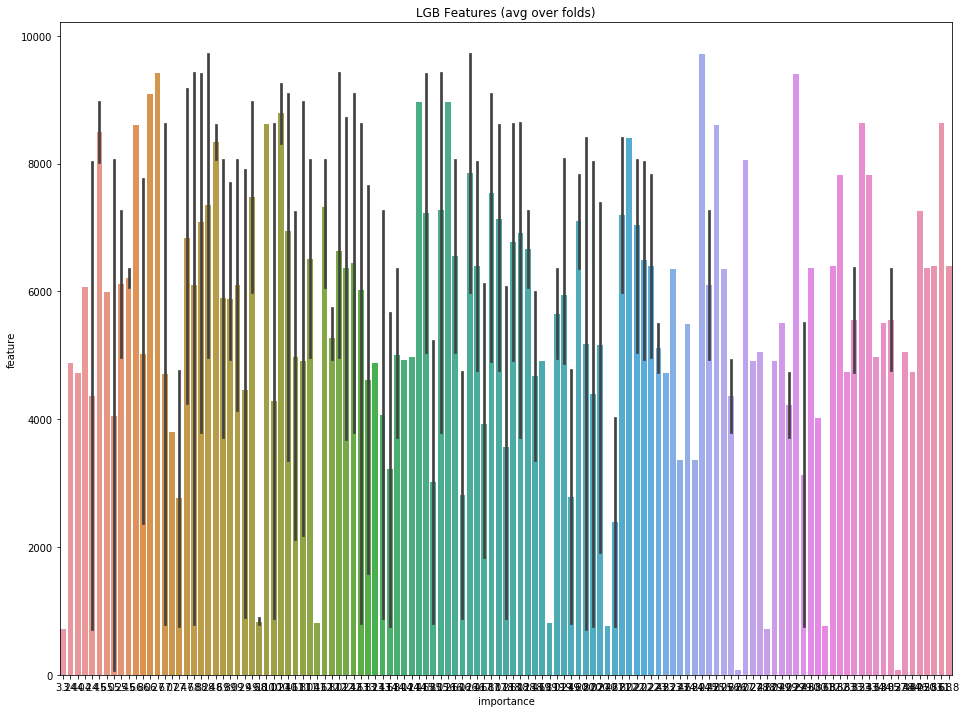

In [42]:
params = {'num_leaves': 54,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501
         }
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)

In [43]:
top_cols = list(feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index)

In [57]:
len(top_cols)

50

In [ ]:
# Taking less columns seriously decreases score.
# X_train_scaled = X_train_scaled[top_cols]
# X_test_scaled = X_test_scaled[top_cols]

Fold 0 started at Sun Feb  3 05:47:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1010]	training's l1: 1.6477	valid_1's l1: 2.07288
Fold 1 started at Sun Feb  3 05:47:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1326]	training's l1: 1.53778	valid_1's l1: 2.01621
Fold 2 started at Sun Feb  3 05:47:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1094]	training's l1: 1.59883	valid_1's l1: 2.12683
Fold 3 started at Sun Feb  3 05:47:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1155]	training's l1: 1.62237	valid_1's l1: 1.9049
Fold 4 started at Sun Feb  3 05:47:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1235]	training's l1: 1.56269	valid_1's l1: 2.06915
CV mean score: 2.0380, std: 0.0752.


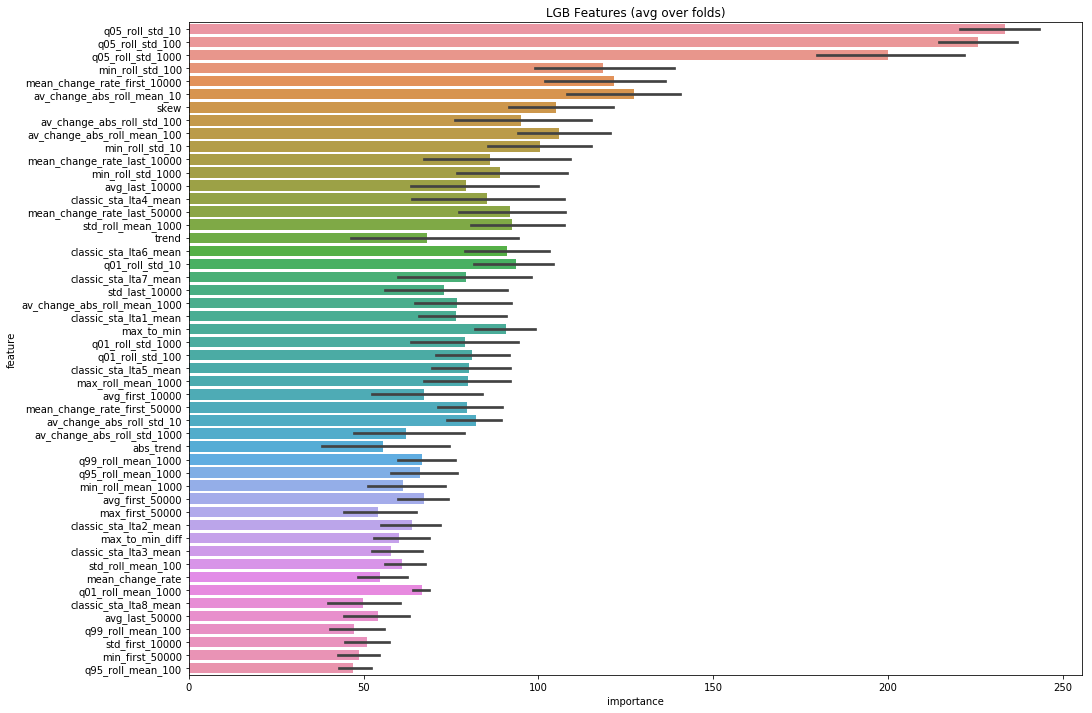

In [46]:
#oof_lgb, prediction_lgb, feature_importance = train_model(X=X_train_scaled, X_test=X_test_scaled, params=params, model_type='lgb', plot_feature_importance=True)

In [123]:
xgb_params = {'eta': 0.05,
              'max_depth': 10,
              'subsample': 0.9,
              'objective': 'reg:linear',
              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4}
oof_xgb, prediction_xgb = train_model(X=X_train_scaled, X_test=X_test_scaled, params=xgb_params, model_type='xgb')

Fold 0 started at Mon Feb  4 23:36:36 2019


ValueError: feature_names may not contain [, ] or <

In [128]:
model = NuSVR(gamma='scale', nu=0.9, C=10.0, tol=0.01)
oof_svr, prediction_svr = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Mon Feb  4 23:38:41 2019
Fold 0. MAE: 2.1043.



KeyboardInterrupt: 

In [67]:
model = NuSVR(gamma='scale', nu=0.7, tol=0.01, C=1.0)
oof_svr1, prediction_svr1 = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Mon Feb  4 21:24:27 2019
Fold 0. MAE: 2.0738.



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [62]:
#model = NuSVR(gamma='scale', nu=0.5, tol=0.01, C=0.1)
#oof_svr2, prediction_svr2 = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

In [ ]:
params = {'loss_function':'MAE'}
oof_cat, prediction_cat = train_model(X=X_train_scaled, X_test=X_test_scaled, params=params, model_type='cat')

In [68]:
model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01)
oof_r, prediction_r = train_model(X=X_train_scaled, X_test=X_test_scaled, params=None, model_type='sklearn', model=model)

Fold 0 started at Mon Feb  4 21:24:46 2019
Fold 0. MAE: 2.1736.



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Stacking
And now let's try stacking :) We can use the same function for it.

In [52]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_svr, oof_svr1, oof_r, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns = ['lgb', 'xgb', 'svr', 'svr1', 'r', 'cat'])
test_stack = np.vstack([prediction_lgb, prediction_xgb, prediction_svr, prediction_svr1, prediction_r, prediction_cat]).transpose()
test_stack = pd.DataFrame(test_stack)

Fold 0 started at Sun Feb  3 07:44:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[31]	training's l1: 1.82973	training's l2: 5.48428	valid_1's l1: 2.09621	valid_1's l2: 7.20252
Fold 1 started at Sun Feb  3 07:44:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[25]	training's l1: 1.88319	training's l2: 5.71511	valid_1's l1: 2.07266	valid_1's l2: 7.22675
Fold 2 started at Sun Feb  3 07:44:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[31]	training's l1: 1.8067	training's l2: 5.33233	valid_1's l1: 2.18256	valid_1's l2: 7.85105
Fold 3 started at Sun Feb  3 07:44:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[30]	training's l1: 1.86447	training's l2: 5.63523	valid_1's l1: 1.96795	valid_1's l2: 6.63293
Fold 4 started at Sun Feb  3 07:44:59 2019
Training until

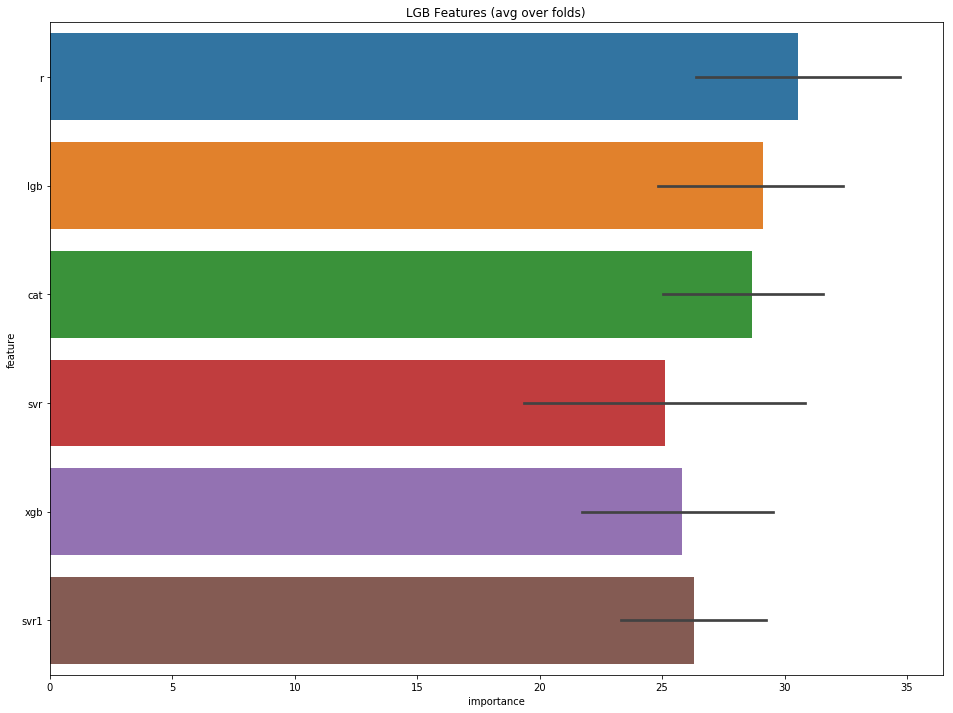

In [53]:
oof_lgb_stack, prediction_lgb_stack, feature_importance = train_model(X=train_stack, X_test=test_stack, params=params, model_type='lgb', plot_feature_importance=True)

Now let's see how do our models perform

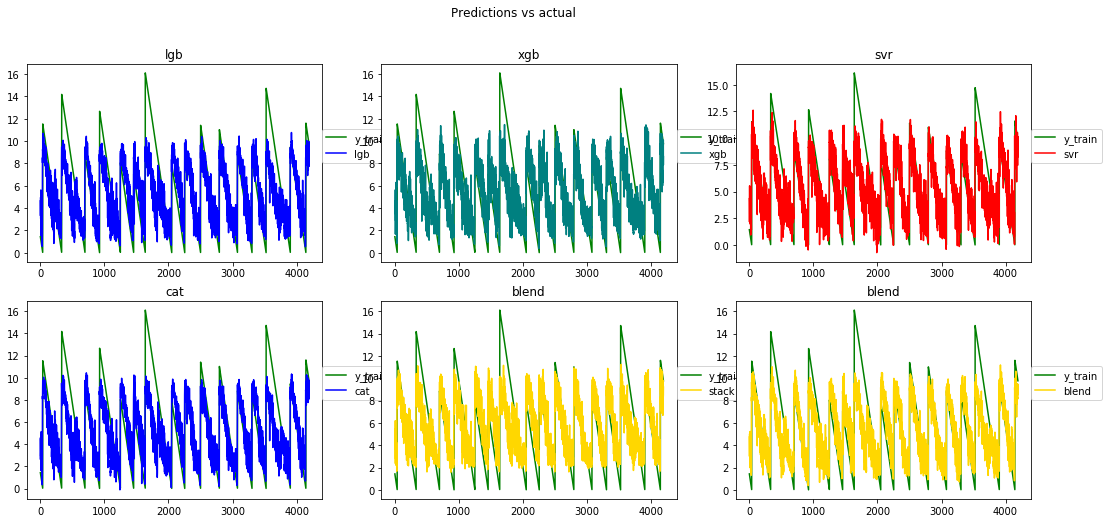

In [54]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb, color='b', label='lgb')
plt.legend(loc=(1, 0.5));
plt.title('lgb');
plt.subplot(2, 3, 2)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_xgb, color='teal', label='xgb')
plt.legend(loc=(1, 0.5));
plt.title('xgb');
plt.subplot(2, 3, 3)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_svr, color='red', label='svr')
plt.legend(loc=(1, 0.5));
plt.title('svr');
plt.subplot(2, 3, 4)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_cat, color='b', label='cat')
plt.legend(loc=(1, 0.5));
plt.title('cat');
plt.subplot(2, 3, 5)
plt.plot(y_tr, color='g', label='y_train')
plt.plot(oof_lgb_stack, color='gold', label='stack')
plt.legend(loc=(1, 0.5));
plt.title('blend');
plt.legend(loc=(1, 0.5));
plt.suptitle('Predictions vs actual');
plt.subplot(2, 3, 6)
plt.plot(y_tr, color='g', label='y_train')
plt.plot((oof_lgb + oof_xgb + oof_svr + oof_svr1 + oof_r + oof_cat) / 6, color='gold', label='blend')
plt.legend(loc=(1, 0.5));
plt.title('blend');
plt.legend(loc=(1, 0.5));
plt.suptitle('Predictions vs actual');

It turned out that stacking is much worse than blending on LB.

In [130]:
prediction_lgb

array([3.98032035, 5.26400442, 5.46794067, ..., 5.115047  , 4.47846419,
       6.4948669 ])

In [132]:
y_test

NameError: name 'y_test' is not defined

In [135]:
#submission['time_to_failure'] = (prediction_lgb + prediction_xgb + prediction_svr + prediction_svr1 + prediction_cat + prediction_r) / 6
submission['time_to_failure'] = prediction_lgb
# submission['time_to_failure'] = prediction_lgb_stack
print(submission.head())
submission.to_csv('submission.csv')

              time_to_failure
seg_id                       
seg_00030f  3.980320351847239
seg_0012b5  5.264004424707027
seg_00184e  5.467940672111402
seg_003339  6.367527252107533
seg_0042cc  5.738673409893822


In [134]:
print('hello')

hello
